Import some standard Python science libraries

In [2]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import glob
import colour
import math
from scipy.optimize import curve_fit
import scipy.io as sio

The calibration values of the monitor used in the G0 experiment

In [3]:
monGamma_P3 = np.array([2.2, 2.2, 2.2])

# relative luminance scaling based on measurements from karl's monitor
monxyY_P3 = np.array([
    [0.6800, 0.3200, 0.2067*1500],
    [0.2650, 0.6900, 0.7164*1500],
    [0.1500, 0.0600, 0.0780*1500]
])
    
monXYZ_P3 = np.zeros((3, 3))
for c in range(3):
    monXYZ_P3[:, c] = colour.xyY_to_XYZ(monxyY_P3[c, :])


monWP_P3 = monXYZ_P3.sum(axis = 1)
max_luminance = monWP_P3[1]

Karl has the same monitor, so we measured the spectra of his RGB primaries to compute radiance of RGB values. The luminance values of Karl's primaries at max activation were also used to compute the relative intensities of the primaries and to adjust the max luminances for the G0 experiment, since those were not reported in the manuscript.

[34.631, 120.06, 13.074, 167.58000000000001, 167.76500000000001]


array([ 0.20665354,  0.71643394,  0.07801647])

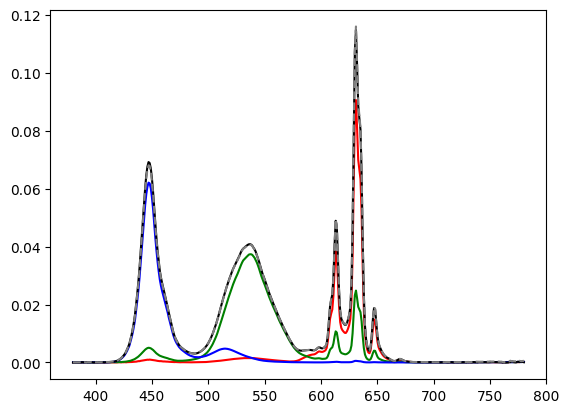

In [4]:
wlns = np.arange(380, 781)
rad_P3 = sio.loadmat('./SPECTRA_Karl_22-Jun-2023.mat')

rs = (rad_P3['SPECTRA'][0][0]['spectralData'][0][0]).flatten()
rlum = rad_P3['SPECTRA'][0][0]['Y'][0][0].flatten()[0]

gs = (rad_P3['SPECTRA'][0][1]['spectralData'][0][0]).flatten()
glum = rad_P3['SPECTRA'][0][1]['Y'][0][0].flatten()[0]

bs = (rad_P3['SPECTRA'][0][2]['spectralData'][0][0]).flatten()
blum = rad_P3['SPECTRA'][0][2]['Y'][0][0].flatten()[0]

ws = (rad_P3['SPECTRA'][0][3]['spectralData'][0][0]).flatten()
wlum = rad_P3['SPECTRA'][0][3]['Y'][0][0].flatten()[0]

# Karl's monitor was in a mode that limits the maximum that the RGB primaries can reach,
# so we compute a correction factor here based on the reports in the G0 paper that the
# monitor can ideally reach a max of 1500 cd/m2 (confirmed in Apple's tech report about
# the monitor).
corrf = [monxyY_P3[0, 2]/rlum, monxyY_P3[1, 2]/glum, monxyY_P3[2, 2]/blum]
w_corrf = monWP_P3[1]/wlum

rs_corr = rs*corrf[0]
gs_corr = gs*corrf[1]
bs_corr = bs*corrf[2]

max_radiance = (ws*w_corrf).sum()

plt.plot(wlns, rs_corr, color="red")
plt.plot(wlns, gs_corr, color="green")
plt.plot(wlns, bs_corr, color="blue")
plt.plot(wlns, ws*w_corrf, color="black")
plt.plot(wlns, rs_corr + gs_corr + bs_corr, color="grey", linestyle="dashed")

print([rlum, glum, blum, wlum, rlum+glum+blum])
[rlum, glum, blum]/wlum


We see that the spectra of the RGB primaries add up to be the same as the spectra recorded for white, which is good.

Now, we define some functions needed for maxRGB analysis and converting the u'v'Y stimulus coordinates to xyY and RGB. Some functions also for converting to LAB and back.

In [5]:
def maxRGB(rgb):
    return np.max(rgb)


def maxWeightRGB(rgbs, wR, wG, wB):
    w_rgbs = np.array([[wR], [wG], [wB]]) * rgbs
    return np.array(np.max(w_rgbs, axis=0)).flatten()


def maxRGB_Shuchen(rgb):
    ws = np.array([0.40, 0.45, 0.15])
    return np.max(ws * rgb)


rand_weights = np.random.rand(1, 3)
def maxRGB_Random(rgb):
    return np.max(rand_weights * rgb)


def luminance(rgb):
    lums = rgb * [monxyY_P3[0, 2], monxyY_P3[1, 2], monxyY_P3[2, 2]]
    return np.array(lums).sum()/max_luminance


def radiance(rgb):
    r = rgb[0]
    g = rgb[1]
    b = rgb[2]

    return (rs_corr*r + gs_corr*g + bs_corr*b).sum()/max_radiance


def rgb2xyz(monxyz, rgb):
    return monxyz @ rgb


def xyz2rgb(monxyz, xyz):
    return np.linalg.inv(monxyz) @ xyz


def xyY2uvY(xyY):
    x = xyY[0]
    y = xyY[1]
    Y = xyY[2]

    u = (4*x) / (-2*x + 12*y + 3)
    v = (9*y) / (-2*x + 12*y + 3)

    return np.array([u, v, Y])


def uvY2xyY(uvY):
    u = uvY[0]
    v = uvY[1]
    Y = uvY[2]

    x = (9*u) / (6*u - 16*v + 12)
    y = (4*v) / (6*u - 16*v + 12)
    
    return np.array([x, y, Y])


lab_delta = 6/29
def lab_f(t):
    if t > lab_delta**3:
        return t ** 0.3333333333333333
    else:
        return t/(3 * (lab_delta**2)) + 4/29


def xyz2lab(XYZ, WP):
    xyz_s = XYZ / WP
    xsf = lab_f(xyz_s[0])
    ysf = lab_f(xyz_s[1])
    zsf = lab_f(xyz_s[2])

    l = 116 * ysf - 16
    a = 500 * (xsf - ysf)
    b = 200 * (ysf - zsf)

    return np.array([l, a, b])


def lab_inv_f(t):
    if t > lab_delta:
        return t ** 3
    else:
        return (3 * (lab_delta**2)) * (t - 4/29)


def lab2xyz(LAB, WP):
    l = LAB[0]
    a = LAB[1]
    b = LAB[2]

    x_pre_f = (l+16)/116 + (a/500)
    y_pre_f = (l+16)/116
    z_pre_f = (l+16)/116 - b/200

    X = WP[0] * lab_inv_f(x_pre_f)
    Y = WP[1] * lab_inv_f(y_pre_f)
    Z = WP[2] * lab_inv_f(z_pre_f)

    return np.array([X, Y, Z])


def rgb2lab_P3(rgb):
    xyz = rgb2xyz(monXYZ_P3, rgb)
    return xyz2lab(xyz, monWP_P3)

In [6]:
rand_weights

array([[ 0.00049804,  0.31433866,  0.14951657]])

The stimuli from Table 1 of the paper in u'v'Y coordinates, which are then transformed to xyY. These lie on the G0 brightness reference boundary.

In [7]:
G0_stims_uvY = np.array([
    [0.448, 0.5024, 72.94], # 1
    [0.3453, 0.4970, 179.31], # 2
    [0.2548, 0.4829, 338.67], # 3
    [0.2333, 0.5556, 361.72], # 4
    [0.2242, 0.5385, 435.82], # 5
    [0.2117, 0.5104, 431.28], # 6
    [0.1201, 0.5092, 334.39], # 7
    [0.1400, 0.5006, 387.97], # 8
    [0.1667, 0.4869, 466.44], # 9
    [0.1415, 0.4180, 310.11], # 10
    [0.1577, 0.4361, 379.57], # 11
    [0.1769, 0.4537, 448.53], # 12
    [0.2537, 0.3307, 181.88], # 13
    [0.2331, 0.3794, 275.61], # 14
    [0.2132, 0.4297, 411.25], # 15
    [0.1978, 0.4683, 530.00]  # 16
])

G0_stims = np.zeros(G0_stims_uvY.shape)
for c in range(len(G0_stims)):
    G0_stims[c, :] = uvY2xyY(G0_stims_uvY[c, :])

G0_stims_LAB = np.zeros(G0_stims_uvY.shape)
G0_stims_XYZ = np.zeros(G0_stims_uvY.shape)
for c in range(len(G0_stims_LAB)):
    xyz = colour.xyY_to_XYZ(G0_stims[c, :])
    G0_stims_XYZ[c, :] = xyz
    G0_stims_LAB[c, :] = xyz2lab(xyz, monWP_P3)

Confirm that all stimuli are within the gamut of the monitor

In [8]:
ciexyz_1931 = pd.read_csv('./ciexyz31_1.csv', header=None)

plank_lasso = np.zeros((len(ciexyz_1931)+4, 2))
for c in range(len(ciexyz_1931)):
    spect = np.zeros((len(ciexyz_1931), ))
    spect[c] = 1.0

    X = (np.array(list(ciexyz_1931[1])) * spect).sum()
    Y = (np.array(list(ciexyz_1931[2])) * spect).sum()
    Z = (np.array(list(ciexyz_1931[3])) * spect).sum()

    x = X/(X + Y + Z)
    y = Y/(X + Y + Z)

    plank_lasso[c, 0] = x
    plank_lasso[c, 1] = y

# linearly interpolate between the first and last point to create the line of purples
c = len(ciexyz_1931)
for a in np.linspace(0, 1, 4):
    b = a*plank_lasso[0, :] + (1-a)*plank_lasso[len(ciexyz_1931)-1, :]
    plank_lasso[c, :] = b

    c += 1


Text(0, 0.5, 'y')

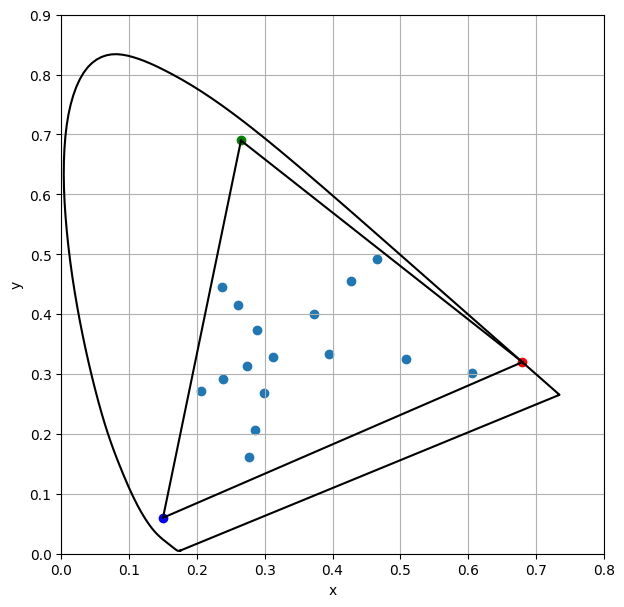

In [9]:
fig, ax = plt.subplots(1, 1, figsize = (7, 7))
plt.grid()
ax.plot(plank_lasso[:, 0], plank_lasso[:, 1], color="black")
ax.plot([monxyY_P3[0, 0], monxyY_P3[1, 0]], [monxyY_P3[0, 1], monxyY_P3[1, 1]], color="black")
ax.plot([monxyY_P3[1, 0], monxyY_P3[2, 0]], [monxyY_P3[1, 1], monxyY_P3[2, 1]], color="black")
ax.plot([monxyY_P3[0, 0], monxyY_P3[2, 0]], [monxyY_P3[0, 1], monxyY_P3[2, 1]], color="black")
ax.scatter(monxyY_P3[0, 0], monxyY_P3[0, 1], color="red")
ax.scatter(monxyY_P3[1, 0], monxyY_P3[1, 1], color="green")
ax.scatter(monxyY_P3[2, 0], monxyY_P3[2, 1], color="blue")
ax.scatter(G0_stims[:, 0], G0_stims[:, 1])
ax.set_xlim((0, 0.8))
ax.set_ylim((0, 0.9))
ax.set_xlabel('x')
ax.set_ylabel('y')

Double check that everything was copied correctly from the paper by trying to reproduce their Fig. 2.

Text(0, 0.5, "v'")

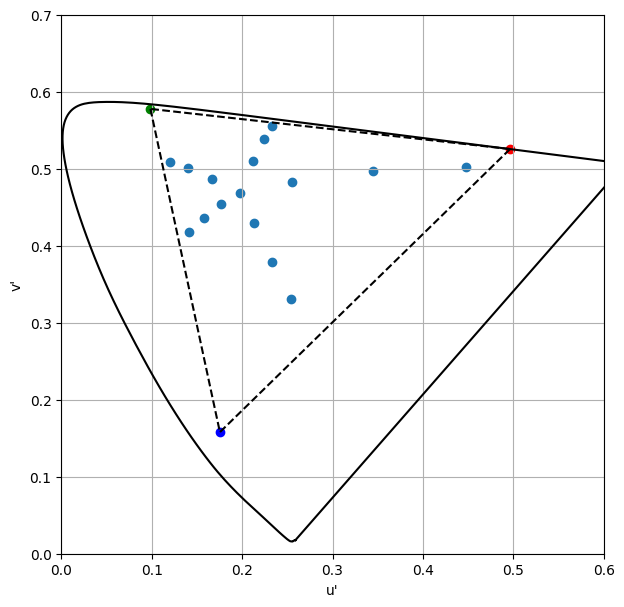

In [10]:
monuvY_P3 = np.zeros(monxyY_P3.shape)
for c in range(3):
    monuvY_P3[c, :] = xyY2uvY(monxyY_P3[c, :])


plank_lasso_uvY = np.zeros((len(plank_lasso), 2))
for c in range(len(plank_lasso)):
    uvY = xyY2uvY(np.array([plank_lasso[c, 0], plank_lasso[c, 1], 100.0]))
    plank_lasso_uvY[c, :] = np.array([uvY[0], uvY[1]])


fig, ax = plt.subplots(1, 1, figsize = (7, 7))
plt.grid()
ax.plot(plank_lasso_uvY[:, 0], plank_lasso_uvY[:, 1], color="black")
ax.plot([monuvY_P3[0, 0], monuvY_P3[1, 0]], [monuvY_P3[0, 1], monuvY_P3[1, 1]], color="black", linestyle="dashed")
ax.plot([monuvY_P3[1, 0], monuvY_P3[2, 0]], [monuvY_P3[1, 1], monuvY_P3[2, 1]], color="black", linestyle="dashed")
ax.plot([monuvY_P3[0, 0], monuvY_P3[2, 0]], [monuvY_P3[0, 1], monuvY_P3[2, 1]], color="black", linestyle="dashed")
ax.scatter(monuvY_P3[0, 0], monuvY_P3[0, 1], color="red")
ax.scatter(monuvY_P3[1, 0], monuvY_P3[1, 1], color="green")
ax.scatter(monuvY_P3[2, 0], monuvY_P3[2, 1], color="blue")
ax.scatter(G0_stims_uvY[:, 0], G0_stims_uvY[:, 1])
ax.set_xlim((0, 0.6))
ax.set_ylim((0, 0.7))
ax.set_xlabel('u\'')
ax.set_ylabel('v\'')

With these stimuli values, we can re-build the brilliance gamma function from Xie's thesis. First, we need a way to interpolate the L* values of the G0 stimuli that were tested. Then, we have some idea of the shape of the whole G0 boundary, which we need for their brilliance function.

[  72.94  179.31  338.67  361.72  435.82  431.28  334.39  387.97  466.44
  310.11  379.57  448.53  181.88  275.61  411.25  530.  ]


(0.0, 0.9)

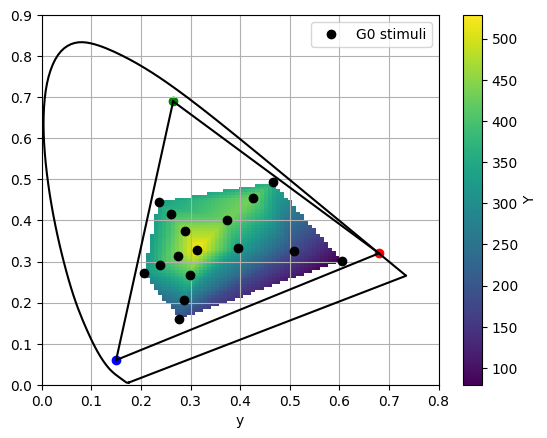

In [47]:
from scipy.interpolate import LinearNDInterpolator
from scipy.interpolate import SmoothBivariateSpline

xs = G0_stims[:, 0]
ys = G0_stims[:, 1]
zs = G0_stims[:, 2]
print(zs)

X = np.linspace(min(xs), max(xs))
Y = np.linspace(min(ys), max(ys))
X, Y = np.meshgrid(X, Y)  # 2D grid for interpolation
brill_interp = LinearNDInterpolator(list(zip(xs, ys)), zs)
Z = brill_interp(X, Y)

# X_s = np.linspace(0.25, 0.5)
# Y_s = np.linspace(0.26, 0.43)
# Xnew, Ynew = np.meshgrid(X_s, Y_s)  # 2D grid for interpolation
# Z = brill_interp(Xnew, Ynew)
# Z = brill_interp(X, Y)
# # brill_spline = SmoothBivariateSpline(Xnew.flatten(), Ynew.flatten(), Z.flatten(), s=1)
# Z_spline = brill_spline(X_s, Y_s)
# Z_spline = np.zeros((len(Y_s), len(X_s)))
# xc = 0
# for x in X_s:
#     yc = 0
#     for y in Y_s:
#         Z_spline[yc, xc] = brill_spline(x, y)
#         yc += 1

#     xc += 1

plt.grid()
plt.plot(plank_lasso[:, 0], plank_lasso[:, 1], color="black")
plt.plot([monxyY_P3[0, 0], monxyY_P3[1, 0]], [monxyY_P3[0, 1], monxyY_P3[1, 1]], color="black")
plt.plot([monxyY_P3[1, 0], monxyY_P3[2, 0]], [monxyY_P3[1, 1], monxyY_P3[2, 1]], color="black")
plt.plot([monxyY_P3[0, 0], monxyY_P3[2, 0]], [monxyY_P3[0, 1], monxyY_P3[2, 1]], color="black")
plt.scatter(monxyY_P3[0, 0], monxyY_P3[0, 1], color="red")
plt.scatter(monxyY_P3[1, 0], monxyY_P3[1, 1], color="green")
plt.scatter(monxyY_P3[2, 0], monxyY_P3[2, 1], color="blue")

# plt.pcolormesh(Xnew, Ynew, Z, shading='auto')
plt.pcolormesh(X, Y, Z, shading='auto')
# plt.pcolormesh(X_s, Y_s, Z_spline, shading='auto')
plt.plot(xs, ys, "ok", label="G0 stimuli")

plt.legend()
cbar = plt.colorbar()
cbar.set_label('Y')
plt.xlabel("x")
plt.xlabel("y")
plt.xlim((0, 0.8))
plt.ylim((0, 0.9))

Now, we can build the brilliance function, which takes an RGB, gets its luminance on the P3 monitor, and then uses the interpolater built in the last step to find the luminance of the G0 color with the same chromaticity. You then calculate the G0 normalized luminance and pass it through their non-linearity.

In [12]:
# brilliance according to the function in fig. 4.5 of Xie's thesis:
# https://scholarworks.rit.edu/cgi/viewcontent.cgi?article=12595&context=theses
# page 66 of the PDF file
def brilliance(rgb):
    xyz = rgb2xyz(monXYZ_P3, rgb)
    xyY = colour.XYZ_to_xyY(xyz)
    g0_boundary_lum = brill_interp(xyY[0], xyY[1])
    g0_normed_lum = xyY[2]/g0_boundary_lum
    return np.power(g0_normed_lum, 1/2.05)

For the G0 stimuli, the "brilliance" function should return 1.0 for all stimuli, since they lie directly on the G0 boundary.

In [13]:
for c in range(len(G0_stims)):
    xyz = colour.xyY_to_XYZ(G0_stims[c, :])
    rgb = xyz2rgb(monXYZ_P3, xyz)

    print(brilliance(rgb))

1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


Convert the stimuli to XYZ and then to the equivalent RGB coordinates for the experiment monitor.
Then, for each stimulus, calculate the different brightness metrics.

In [14]:
bs = np.zeros((len(G0_stims)))
bs_shu = np.zeros((len(G0_stims)))
bs_rand = np.zeros((len(G0_stims)))
bs_rad = np.zeros((len(G0_stims)))
bs_lum = np.zeros((len(G0_stims)))

G0_rgbs = np.zeros((3, len(G0_stims)))

for c in range(len(G0_stims)):
    xyz = colour.xyY_to_XYZ(G0_stims[c, :])
    rgb = xyz2rgb(monXYZ_P3, xyz)

    bs[c] = maxRGB(rgb)
    bs_shu[c] = maxRGB_Shuchen(rgb)
    bs_rand[c] = maxRGB_Random(rgb)
    bs_rad[c] = radiance(rgb)
    bs_lum[c] = luminance(rgb)
    
    G0_rgbs[:, c] = rgb

Summarize the results by looking at the mean and standard deviation of the brigthness estimates for the G0 stimuli.

In [15]:
[[np.mean(bs), np.mean(bs_shu), np.mean(bs_rand), np.mean(bs_rad), np.mean(bs_lum)],
 [np.std(bs), np.std(bs_shu), np.std(bs_rand), np.std(bs_rad), np.std(bs_lum)]]

[[0.3684550068836675,
  0.13705531937576179,
  0.16158699039996621,
  0.23769558834121751,
  0.23080819431958177],
 [0.055437304030212992,
  0.022667399376257988,
  0.074349668281129808,
  0.070250793532119604,
  0.0776099104052487]]

Using the RGBs of the stimuli, fit a max-weighted RGB function with the assumption that all colors on the G0 boundary are indeed equally bright, where all of their brightness values should ideally be equal to the same constant value. For simplicity, I choose the mean response from Shuchen's max-weighted RGB function, which has been found to be the best so far in various experiments.

In [16]:
popt, pcov = curve_fit(maxWeightRGB, G0_rgbs, np.mean(bs_shu)*np.ones((len(G0_stims))))

The fitted weights

In [17]:
popt

array([ 0.36593642,  0.42763098,  0.33796619])

The brightness values on the 10-bit [0, 1] scale.

In [18]:
bs_fit = maxWeightRGB(G0_rgbs, *popt)
bs_fit

array([ 0.07785488,  0.13369912,  0.15559136,  0.13591309,  0.15314056,
        0.136068  ,  0.12328549,  0.1344811 ,  0.14702322,  0.12722933,
        0.12966907,  0.13163532,  0.13876548,  0.14608618,  0.14165336,
        0.14590851])

We can get some idea of which maxRGB function is the most likely to specify all G0 stimuli as "equally bright" by comparing the mean value to the overall spread of the responses.

In [19]:
[np.max(bs_fit), np.min(bs_fit), np.mean(bs_fit)]

[0.15559135612931707, 0.077854882436800568, 0.13487525331106021]

This is similar to a contrast ratio. Just find the function that has smallest deviation relative to the magnitude of the response.

In [20]:
[
    (np.max(bs) - np.min(bs))/np.mean(bs),
    (np.max(bs_shu) - np.min(bs_shu))/np.mean(bs_shu),
    (np.max(bs_rand) - np.min(bs_rand))/np.mean(bs_rand),
    (np.max(bs_rad) - np.min(bs_rad))/np.mean(bs_rad),
    (np.max(bs_lum) - np.min(bs_lum))/np.mean(bs_lum),
    (np.max(bs_fit) - np.min(bs_fit))/np.mean(bs_fit)
]

[0.59571900875056061,
 0.61998801694831152,
 1.3231700581676653,
 1.2499869648223645,
 1.3187220606294485,
 0.57635831469568677]

I also tried other methods, like comparing the standard deviation to the mean or computing (max-min)/(max+min). The rank order of the functions is always the same.

So, the fitted function comes closest to calling all of them equally bright, which is to be expected. However, does this mean that they are actually perceived as equally bright or just "as close as can be given the constraints of the stimulus set"? In other words, the question still remains of what is a JND on the brightness scale. We can estimate this from slide 34 of Karl's "Luminance 100 years" talk.

In [21]:
bJND = 1/1.65 # just take the inverse of the slope of the psychometric function
bJND = bJND/100 # since it was in units of 100% and we are working in [0,1] units
bJND

0.006060606060606061

In [22]:
bs_diffs = []
for c in range(len(bs_fit)):
    for c2 in range(len(bs_fit)):
        if c == c2:
            continue

        bs_diffs.append(np.abs(bs_fit[c] - bs_fit[c2]))

detect_diff = (np.array(bs_diffs) > bJND).sum()
seen_as_equal = (np.array(bs_diffs) < bJND).sum()

seen_as_equal/(detect_diff + seen_as_equal)

0.25

So, it seems that only 25% of all possible G0 pairs would be seen as equal in a maxRGB world.
I can accept that the G0 stimuli appear equally bright, but I still assume that it is because of something odd happening at the boundary between two modes of color appearance.

What if we use Shuchen's function?

In [23]:
bs_diffs = []
for c in range(len(bs_shu)):
    for c2 in range(len(bs_shu)):
        if c == c2:
            continue

        bs_diffs.append(np.abs(bs_shu[c] - bs_shu[c2]))

detect_diff = (np.array(bs_diffs) > bJND).sum()
seen_as_equal = (np.array(bs_diffs) < bJND).sum()

seen_as_equal/(detect_diff + seen_as_equal)

0.13333333333333333

With Shuchen's function, then only 13.33% of possible G0 pairs are classified as equally bright.

Here are the brightness values for the G0 stimuli, according to Shuchen's function.

In [24]:
bs_shu

array([ 0.08510209,  0.14614465,  0.17007474,  0.1485647 ,  0.16739581,
        0.14873403,  0.12973445,  0.14151569,  0.15471388,  0.10566815,
        0.12377769,  0.13852105,  0.10555792,  0.1245971 ,  0.14627921,
        0.15650394])

We can get an idea of how "robust" the max-weighted RGB is by trying all combinations of weights, with the constraint that they add up to 1, and testing how likely it is to classify all G0 stimuli as equally bright by looking at the same "contrast ratio" as before, as a measure of deviation from a common value.

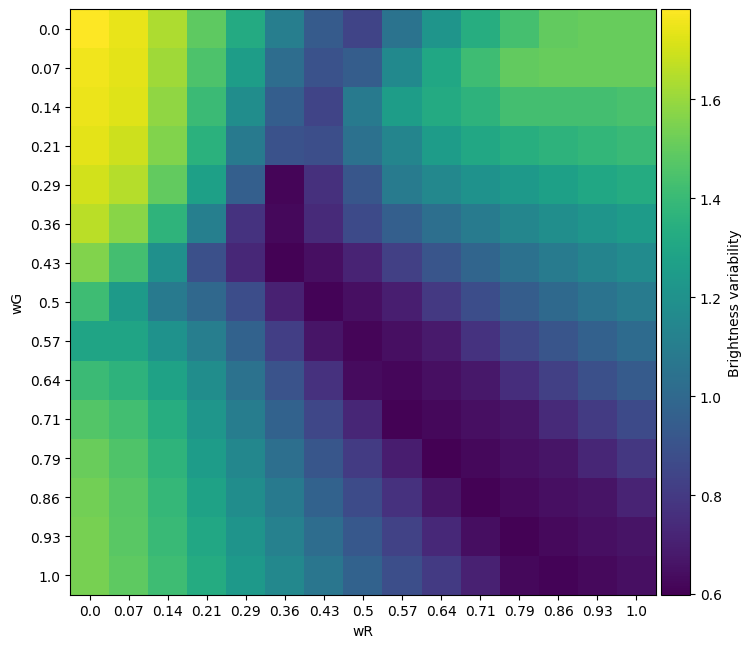

In [25]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

nws = 15
vars = np.zeros((nws, nws))
xlabs = []
ylabs = []
wrc = 0
for wr in np.linspace(0, 1, nws):
    wgc = 0
    for wg in np.linspace(0, 1, nws):
        wb = 1.0 - (wr + wg)

        bs = maxWeightRGB(G0_rgbs, wr, wg, wb)
        vars[wgc, wrc] = (np.max(bs) - np.min(bs))/np.mean(bs)

        if wrc == 0:
            ylabs.append(str(np.round(wg, 2)))

        wgc += 1

    xlabs.append(str(np.round(wr, 2)))
    wrc += 1

fig, ax = plt.subplots(figsize = (8, 8))
im = ax.imshow(vars)
ax.set_xlabel('wR')
ax.set_ylabel('wG')
ax.set_xticks(np.arange(nws), labels=xlabs)
ax.set_yticks(np.arange(nws), labels=ylabs)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, label="Brightness variability")

Try making a plot like Jing's.

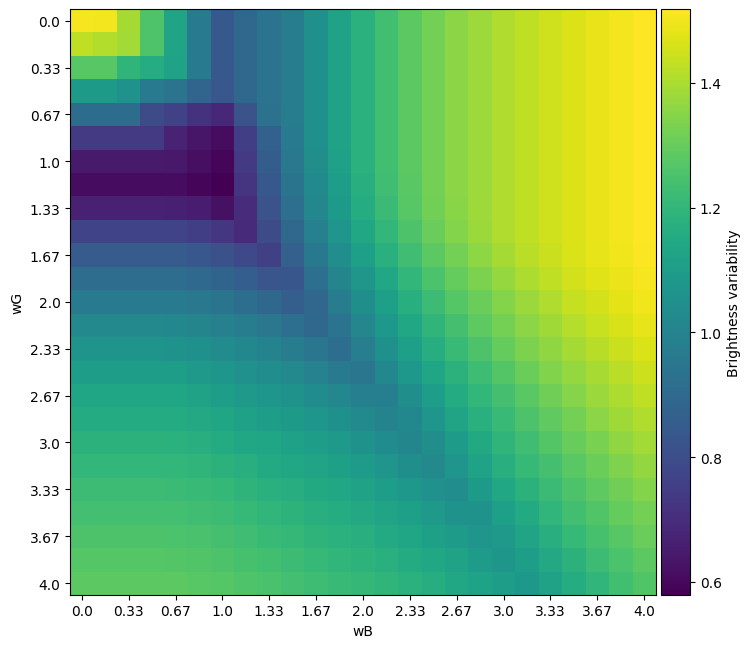

In [26]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

jing_ciergb = [0.85, 0.62]
jing_rad = [0.9, 0.7]
jing_mon = [1.0, 1.0]
jing_vlam = [3.58, 0.53]

nws = 25
vars = np.zeros((nws, nws))
xlabs = []
ylabs = []
wbc = 0
for wb in np.linspace(0, 4, nws):
    wgc = 0
    for wg in np.linspace(0, 4, nws):
        wr = 1.0

        bs = maxWeightRGB(G0_rgbs, wr, wg, wb)
        vars[wgc, wbc] = (np.max(bs) - np.min(bs))/np.mean(bs)

        if wbc == 0:
            ylabs.append(str(np.round(wg, 2)))

        wgc += 1

    xlabs.append(str(np.round(wb, 2)))
    wbc += 1

fig, ax = plt.subplots(figsize = (8, 8))
im = ax.imshow(vars)
ax.set_xlabel('wB')
ax.set_ylabel('wG')
ax.set_xticks(np.arange(0, nws, 2), labels=xlabs[::2])
ax.set_yticks(np.arange(0, nws, 2), labels=ylabs[::2])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(im, cax=cax, label="Brightness variability")

In the heatmap above, dark blue is "better" and we re-confirm that the scipy optimization function found the best fit.

Now, we can see what the different measures give for different hues of equal L* and C* (so, basically going around a hue circle in LAB space).

In [27]:
nhues = 100
thetas = np.linspace(0, 2*np.pi, nhues)

const_hues_bs_basic = np.zeros((nhues))
const_hues_bs_shu = np.zeros((nhues))
const_hues_bs_fit = np.zeros((nhues))
const_hues_bs_rand = np.zeros((nhues))
const_hues_bs_lum = np.zeros((nhues))
const_hues_bs_rad = np.zeros((nhues))
const_hues_bs_brill = np.zeros((nhues))

c = 0
lstar = 31
cstar = 20
for theta in thetas:
    astar = cstar*np.cos(theta)
    bstar = cstar*np.sin(theta)

    xyz = lab2xyz(np.array([lstar, astar, bstar]), monWP_P3)
    rgb = xyz2rgb(monXYZ_P3, xyz)

    print(rgb)

    const_hues_bs_basic[c] = maxRGB(rgb)
    const_hues_bs_shu[c] = maxRGB_Shuchen(rgb)
    const_hues_bs_fit[c] = maxWeightRGB(rgb, *popt)[0]
    const_hues_bs_rand[c] = maxRGB_Random(rgb)
    const_hues_bs_lum[c] = luminance(rgb)
    const_hues_bs_rad[c] = radiance(rgb)
    const_hues_bs_brill[c] = brilliance(rgb)

    c += 1

[ 0.12104444  0.05070353  0.06723432]
[ 0.12239708  0.05066308  0.06402132]
[ 0.12345821  0.05069479  0.06091802]
[ 0.12422588  0.05079824  0.05793355]
[ 0.12470032  0.05097253  0.0550755 ]
[ 0.12488386  0.05121633  0.05234997]
[ 0.12478085  0.05152785  0.04976169]
[ 0.12439757  0.05190494  0.04731405]
[ 0.12374203  0.05234501  0.04500929]
[ 0.1228239   0.05284516  0.04284862]
[ 0.12165431  0.05340216  0.04083227]
[ 0.12024568  0.05401246  0.03895973]
[ 0.11861158  0.05467229  0.03722981]
[ 0.11676649  0.05537765  0.0356408 ]
[ 0.11472568  0.05612438  0.03419059]
[ 0.112505    0.05690815  0.0328768 ]
[ 0.11012068  0.05772455  0.03169688]
[ 0.10758923  0.05856911  0.03064823]
[ 0.10492719  0.05943734  0.02972832]
[ 0.10215105  0.06032473  0.0289347 ]
[ 0.09927704  0.06122686  0.02826518]
[ 0.09632106  0.06213933  0.02771781]
[ 0.09329852  0.06305788  0.02729099]
[ 0.09022425  0.06397837  0.02698347]
[ 0.08711242  0.0648968   0.02679445]
[ 0.08397642  0.06580933  0.02672351]
[ 0.08082888

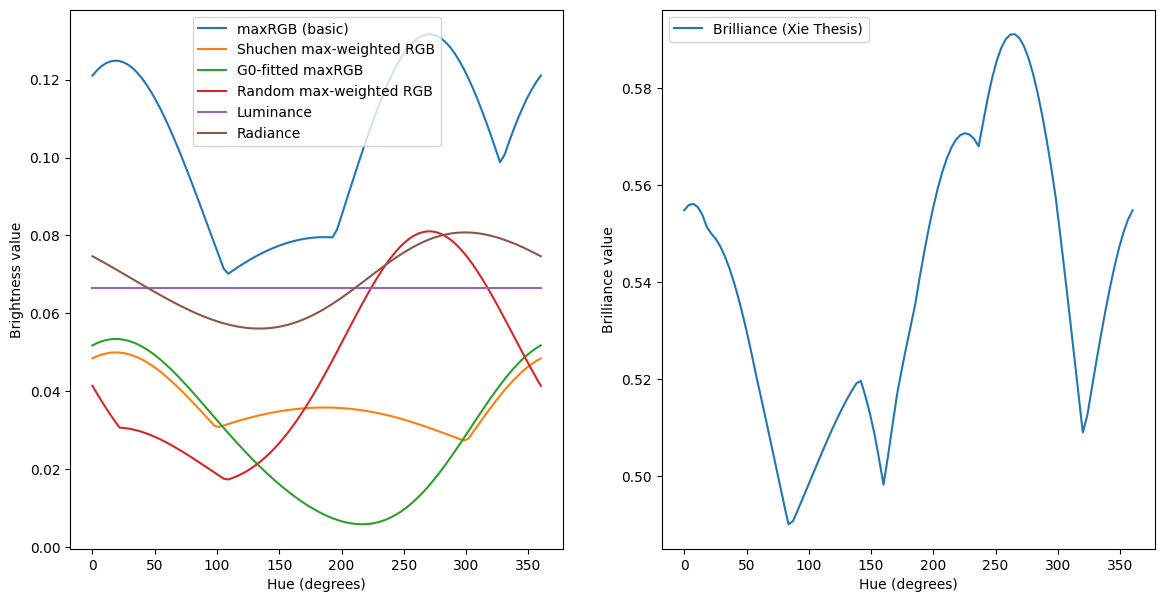

In [28]:
fig, ax = plt.subplots(1, 2, figsize = (14, 7))
ax[0].plot(np.rad2deg(thetas), const_hues_bs_basic, label='maxRGB (basic)')
ax[0].plot(np.rad2deg(thetas), const_hues_bs_shu, label='Shuchen max-weighted RGB')
ax[0].plot(np.rad2deg(thetas), const_hues_bs_fit, label='G0-fitted maxRGB')
ax[0].plot(np.rad2deg(thetas), const_hues_bs_rand, label='Random max-weighted RGB')
ax[0].plot(np.rad2deg(thetas), const_hues_bs_lum, label='Luminance')
ax[0].plot(np.rad2deg(thetas), const_hues_bs_rad, label='Radiance')
ax[0].set_xlabel('Hue (degrees)')
ax[0].set_ylabel('Brightness value')
ax[0].legend()

ax[1].plot(np.rad2deg(thetas), const_hues_bs_brill, label='Brilliance (Xie Thesis)')
ax[1].set_xlabel('Hue (degrees)')
ax[1].set_ylabel('Brilliance value')
ax[1].legend()


I showed the brilliance function results in a separate plot, because it scales everything differently by doing a normalization and then throwing that through a power function, which then makes it harder to see what is going on with the other functions, so pay attention to the scales in each plot!

The G0-fitted function does some things the same as Shuchen's function, but makes different estimates in the "Green" region of LAB space.

Curiously, in terms of form/shape, the basic un-weighted maxRGB and the brilliance function share some similarities to Evans' original brilliance function, with un-weighted maxRGB being most similar? Hmm... I might be over-interpreting :-D

Note that the x-axis is shifted relative to the plots above, in order to ease comparison with Evans' function, since they used a wavelength axis that starts at blue on the left.

In [29]:
nhues = 100
thetas = np.linspace(3/2*np.pi, (3/2+2)*np.pi, nhues)

const_hues_bs_basic = np.zeros((nhues))
const_hues_bs_shu = np.zeros((nhues))
const_hues_bs_brill = np.zeros((nhues))
const_hues_bs_fit = np.zeros((nhues))

c = 0
lstar = 31
cstar = 20
for theta in thetas:
    astar = cstar*np.cos(theta)
    bstar = cstar*np.sin(theta)

    xyz = lab2xyz(np.array([lstar, astar, bstar]), monWP_P3)
    rgb = xyz2rgb(monXYZ_P3, xyz)

    const_hues_bs_basic[c] = maxRGB(rgb)
    const_hues_bs_shu[c] = maxRGB_Shuchen(rgb)
    const_hues_bs_fit[c] = maxWeightRGB(rgb, *popt)[0]
    const_hues_bs_brill[c] = brilliance(rgb)

    c += 1

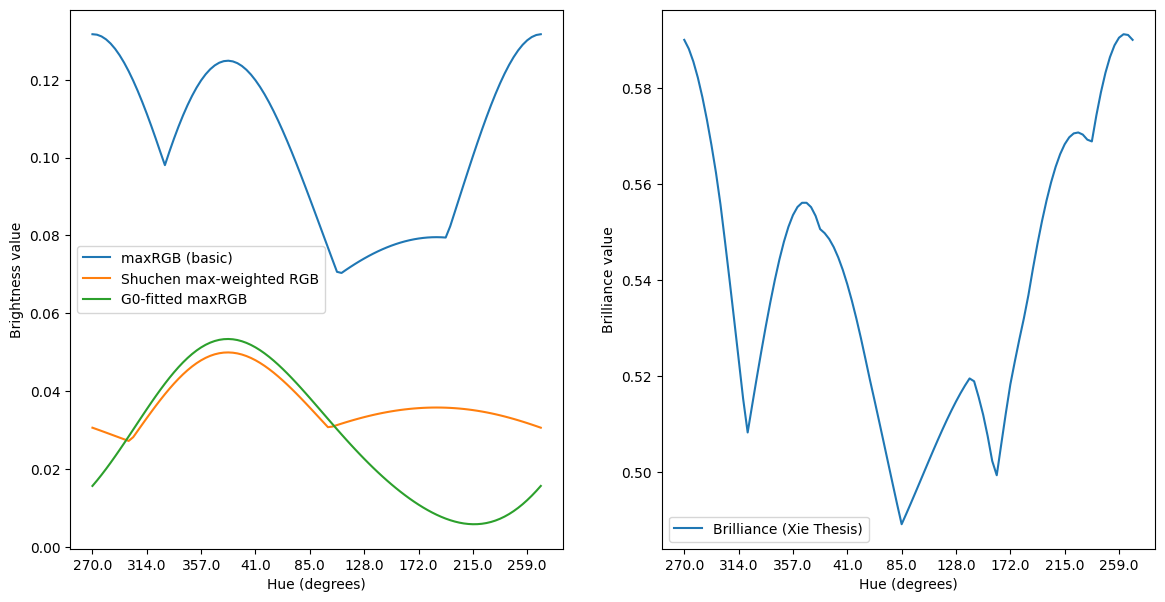

In [30]:
fig, ax = plt.subplots(1, 2, figsize = (14, 7))
ax[0].plot(np.rad2deg(thetas), const_hues_bs_basic, label='maxRGB (basic)')
ax[0].plot(np.rad2deg(thetas), const_hues_bs_shu, label='Shuchen max-weighted RGB')
ax[0].plot(np.rad2deg(thetas), const_hues_bs_fit, label='G0-fitted maxRGB')
ax[0].set_xlabel('Hue (degrees)')
ax[0].set_ylabel('Brightness value')
ax[0].legend()

ax[1].plot(np.rad2deg(thetas), const_hues_bs_brill, label='Brilliance (Xie Thesis)')
ax[1].set_xlabel('Hue (degrees)')
ax[1].set_ylabel('Brilliance value')
ax[1].legend()

xts = []
xlabs = []
for c in range(0, len(thetas), 12):
    xts.append(np.rad2deg(thetas[c]))
    xlabs.append(str(np.round(np.rad2deg(np.mod(thetas[c], 2*np.pi)))))

ax[0].set_xticks(xts, labels=xlabs)
ax[1].set_xticks(xts, labels=xlabs)


![Evan's brilliance](evans_brill.png)

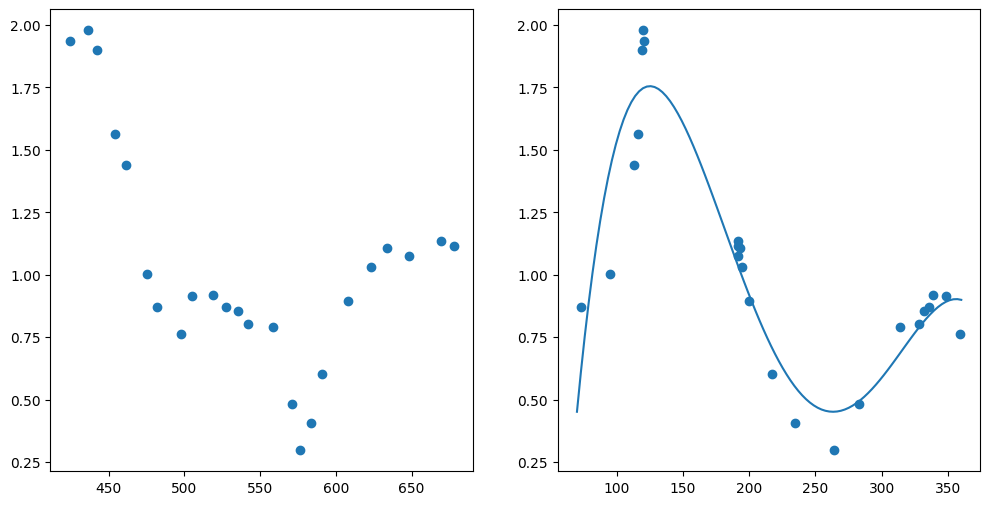

In [33]:
# wlns, log(Ls/Lb)
orig_brill_data = np.array([
    [424.3213709212088, 1.9349077663660985],
    [436.1148351671836, 1.9789526406688767],
    [442.43168118217454, 1.9006444364696613],
    [454.0078758443239, 1.562155927325105],
    [461.25399455472564, 1.4399624172473582],
    [475.6375971836164, 1.0043087053681972],
    [481.92238703050185, 0.8695611495128177],
    [498.0833260910139, 0.7631569350143113],
    [505.1663145237237, 0.9137496353974182],
    [518.8468185321694, 0.9201922105263907],
    [527.4061715959556, 0.8701316066295006],
    [535.3489776931813, 0.854553739212387],
    [541.9999202157594, 0.8044692000518596],
    [558.2142862231138, 0.7921305716469602],
    [570.7607142399197, 0.48187370596230483],
    [576.0628044445521, 0.29694586989184923],
    [583.7587780473661, 0.40678479472227247],
    [590.8684799534972, 0.6044102881521827],
    [607.8917299360444, 0.8962250332044914],
    [623.2355928895145, 1.0312438553810908],
    [633.4565240000969, 1.1066239789953738],
    [648.3879309239443, 1.0754562765293285],
    [669.4142839435641, 1.1352944356219539],
    [677.9896650914029, 1.1134535075531455],
])

brill_hues = np.zeros((len(orig_brill_data), ))
for c in range(len(orig_brill_data)):
    wln = np.round(orig_brill_data[c, 0])

    idx = np.argmin(np.abs(ciexyz_1931[0] - wln))
    
    spect = np.zeros((len(ciexyz_1931), ))
    spect[idx] = 1.0

    X = (ciexyz_1931[1] * spect).sum()
    Y = (ciexyz_1931[2] * spect).sum()
    Z = (ciexyz_1931[3] * spect).sum()

    lab = xyz2lab(np.array([X, Y, Z]), monWP_P3)

    brill_hues[c] = np.rad2deg(math.atan2(lab[2], lab[1]) + np.pi)


fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(orig_brill_data[:, 0], orig_brill_data[:, 1])
ax[1].scatter(brill_hues, orig_brill_data[:, 1])

z = np.polyfit(brill_hues, orig_brill_data[:, 1], 4)
p = np.poly1d(z)
xp = np.linspace(70, 360, 100)
ax[1].plot(xp, p(xp))

In [36]:
c = 0
rs = np.linspace(0, 1, 10)
sats = np.zeros((len(rs)))
for r in rs:
    lab = rgb2lab_P3(np.array([r, 0, 0]))
    lstar = lab[0]
    a = lab[1]
    b = lab[2]

    cstar = np.sqrt(np.power(a, 2.0) + np.power(b, 2.0))
    sats[c] = cstar/lstar

    c += 1

sats

/tmp/ipykernel_15009/541723125.py:11: RuntimeWarning: invalid value encountered in scalar divide
  sats[c] = cstar/lstar


array([        nan,  3.24004138,  2.87153916,  2.7385917 ,  2.66596469,
        2.6188006 ,  2.58508317,  2.55945483,  2.5391287 ,  2.52249652])